In [1]:
#export
"""Browser automation tool. This is kinda like selenium, but way more awesome.

How it works is that I've developed a chrome extension that can communicate with
one of my servers, and functions here also communicate with it. After installing
the extension, you can open up a bunch of chrome windows, then using this module,
you can "attach" to a specific window. Then using methods provided here, you can
execute any random pieces of code as it you're in chrome's console.

This works already for some of my projects, but it takes too much time to document
everything, and I have so many other things to do, so if you're interested, ping
me at 157239q@gmail.com and I'll finalize this module. Some examples of what this
can do:

- https://mlexps.com/other/43-touhou/
- https://mlexps.com/other/44-gensokyo-days/

(yes, I'm still addicted to touhou and it's slowly destroying my life)"""
import k1lib, math, numpy as np, random, base64, json, time, asyncio, threading, traceback, html
from collections import defaultdict, deque; import k1lib.cli as cli; import k1lib.kws as kws
websockets = k1lib.dep.websockets
__all__ = ["newBrowser", "Browser", "Element", "Locator", "BrowserCancel", "BrowserGroup"]

/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#export
autoMsgIdx = k1lib.AutoIncrement(prefix=f"_Python_{round(random.random()*1e9)}_{round(time.time())}_")
_browserAutoIdx = k1lib.AutoIncrement(prefix="_browser_"); _browserAnsD = dict(); _browserQueue = deque()
def bThread(): # runs a thread that takes in requests to create new browsers, then spits it out
    loop = asyncio.new_event_loop(); asyncio.set_event_loop(loop)
    async def inner(): # all future browser async interactions happens in this newly-created event loop, instead of the main loop of the notebooks
        while True:
            if len(_browserQueue) == 0: await asyncio.sleep(0.01)
            else: idx, _ = _browserQueue.popleft(); _browserAnsD[idx] = Browser()
    loop.run_until_complete(inner())
_bThread_started = [False]
def _start_bThread():
    if _bThread_started[0]: return
    _bThread_started[0] = True; threading.Thread(target=bThread, daemon=True).start()

In [3]:
#export
k1lib.settings.add("zircon", k1lib.Settings()
                   .add("http_server", "https://zircon.mlexps.com")
                   .add("ws_server", "wss://ws.zircon.mlexps.com"),
    "from k1lib.zircon module");

In [4]:
#export
from urllib.parse import urlparse
def newBrowser() -> "Browser":
    """Creates a new browser"""
    websockets.version; _start_bThread() # here to warn users if websockets is not installed
    idx = _browserAutoIdx(); _browserQueue.append([idx, 0])
    while idx not in _browserAnsD: time.sleep(0.01)
    ans = _browserAnsD[idx]; del _browserAnsD[idx]; return ans
class Browser: # controlling over selen.mlexps.com
    def __init__(self):
        self._msgs = {}; self.ws = None; self._ext_ws_updated = False
        self.extId = None; self.__pageInfo = None; self.clientId = None
        self._destroyed = False; self._elements = []
        asyncio.create_task(self._handshake())
    def close(self): self._destroyed = True
    async def _handshake(self):
        async with kws.WsClient(f"{k1lib.settings.zircon.ws_server}/handshake/client") as ws:
            while True:
                asyncio.create_task(ws.send({"type": "connect"})); msg = await ws.recv()
                if msg["type"] == "connect_res": self.clientId = msg["clientId"]; break
        await self._start()
    async def _start(self):
        async with kws.WsClient(f"{k1lib.settings.zircon.ws_server}/connect/client/{self.clientId}") as ws:
            self.ws = ws
            while not self._destroyed:
                msg = await ws.recv()
                if msg["type"] == "ext_ws_updated": self._ext_ws_updated = True; continue
                self._msgs[msg["idx"]] = msg
    async def send(self, d) -> "res": # always return if successful. If not successful then will throw an error instead!
        if self.ws is None: # connect guard
            print("Connecting to server...")
            while self.ws is None: await asyncio.sleep(0.01)
            print("Connected")
        msgIdx = autoMsgIdx(); await self.ws.send({"src": "Python", "type": "cmd", "idx": msgIdx, **d}); startTime = time.time()
        while msgIdx not in self._msgs:
            await asyncio.sleep(0.01) # resends if return message is not found for quite a while. kws module should have handled
            # this correctly, but there might be a case where websockets module declares that the message has passed through, but
            # it hasn't actually passed through yet. Sounds improbable, but seems like it could happen in some of my tests
            if time.time() - startTime > 20: await self.ws.send({"src": "Python", "type": "cmd", "idx": msgIdx, **d}); startTime = time.time()
        msg = self._msgs[msgIdx]; del self._msgs[msgIdx]
        if "success" in msg and not msg["success"]: raise Exception(msg.get("reason", "Failure on Chrome extension, no reason logged"))
        if "chromeRes" in msg: return msg["chromeRes"]
        return msg
    async def scan(self, groupPath:"str|list[str]"=None):
        """Scans for all attached Extensions in the system.
Example::

    b = zircon.newBrowser()
    await b.scan()                    # grab metadata about every Extension that's ready
    await b.scan("touhou")            # grab metadata for Extensions in `touhou` group only
    await b.scan(["touhou", "mint2"]) # grab metadata for Extensions in `touhou` or `mint2` groups

The result might look something like this:

.. code-block:: text

    {'_ext_254175259_1701581542_5': {'basics': {'title': '',
       'url': 'https://zircon.mlexps.com/'},
      'tabInfo': {'tabId': 872280718,
       'data': {'extId': '_ext_254175259_1701581542_5', 'groupPath': 'touhou'}},
      'lastUpdated': 1701584077.7896328,
      'lastPing': 1701587171.1521692},
     '_ext_254175259_1701581542_11': {'basics': {'title': '',
       'url': 'https://zircon.mlexps.com/'},
      'tabInfo': {'tabId': 872280722,
       'data': {'extId': '_ext_254175259_1701581542_11', 'groupPath': 'touhou'}},
      'lastUpdated': 1701583562.7153254,
      'lastPing': 1701587171.2784846}}

:param groupPath: (optional) If specified, only returns metadata for Extensions that
    have the specified group"""
        res = (await self.send({"cmd": "scan"}))["exts"].items() | cli.filt(lambda x: x.get("tabInfo", None) and x.get("basics", None), 1)
        if groupPath is None: return res | cli.toDict()
        if isinstance(groupPath, str): return res | cli.filt(lambda x: groupPath in x["tabInfo"]["bgData"]["config"]["groupPaths"], 1) | cli.toDict()
        else:
            def f(x):
                gps = set(x["tabInfo"]["bgData"]["config"]["groupPaths"])
                for gp in groupPath:
                    if gp in gps: return True
            return res | cli.filt(f, 1) | cli.toDict()
    async def pickExt(self, extId:str): self.extId = extId; self.__pageInfo = None; res = await self.send({"cmd": "pickExt", "extId": extId}); return "ok"
    async def pickExtFromGroup(self, groupName:str):
        return await self.pickExt((await self.scan(groupName)).keys() | cli.item())
    async def goto(self, url, timeout=15):
        """
Typical times for this to be waiting for page change confirmation:

- https://en.touhouwiki.net/wiki/Touhou_Wiki: 4.42s
- https://www.google.com: 5s
- https://mlexps.com: 5.2s
- https://www.amazon.com: 6.2s
- https://www.youtube.com: 9.4s

Quite a distribution. So I figure 15s would be a reasonable middle ground

:param url: url to navigate the page to 
:param timeout: will hang until received confirmation that the extension has been
    loaded on the new page. If has not received anything after this many seconds,
    will return regardless"""
        self._ext_ws_updated = False; res = await self.send({"cmd": "goto", "url": url})
        # wait until page has reloaded, and extension reconnected, or 10s has passed
        startTime = time.time()
        while not self._ext_ws_updated:
            await asyncio.sleep(0.1)
            if time.time() - startTime > timeout: print(f"{timeout}s up, breaking..."); break
        return res
    def _addE(self, d) -> "Element": return Element(self, {"mode": "localElems", "idx": d["idx"]}, d)
    # return e #self.elements.append(e); return e # was experimenting with notifying elements they're now invalid
    async def querySelector(self, selector:str) -> "Element":
        return self._addE(await self.send({"cmd": "querySelector", "selector": selector}))
    async def querySelectorAll(self, selector:str) -> "list[Element]":
        return [self._addE(d) for d in await self.send({"cmd": "querySelectorAll", "selector": selector})]
    async def window(self) -> "Element": return self._addE(await self.send({"cmd": "window"}))
    async def document(self) -> "Element": return self._addE(await self.send({"cmd": "document"}));
    async def locate(self, s:str) -> "list[Element]":
        """Locates text somewhere and returns plausible Elements"""
        return [self._addE(d) for d in await self.send({"cmd": "locate", "selector": None, "s": s}) if d["tag"].lower() != "body"]
    async def locate2(self, locator:"Locator", depth:int=20, width:int=100):
        return {k:self._addE(v) for k,v in (await self.send({"cmd": "locate2", "selector": None, "locator": locator.json(), "depth": depth, "width": width})).items()}
    async def _pageInfo(self):
        if self.__pageInfo: return self.__pageInfo
        while True:
            self.__pageInfo = (await self.scan())[self.extId]
            if "basics" in self.__pageInfo and "url" in self.__pageInfo["basics"]: return self.__pageInfo
            asyncio.sleep(0.01)
    async def scrollDown(self, timeout=120, step=3000, sleep=5):
        """Scrolls <step> pixels down continuously every <sleep> seconds, until can't, or time exceeds <timeout>"""
        window = await self.window(); startTime = time.time()
        newY = float("-inf")
        while time.time() - startTime < timeout:
            await window.func("scrollBy", [0, step]); await asyncio.sleep(sleep)
            oldY = newY; newY = await window.value("scrollY")
            if newY <= oldY: break
    def _toLinks(self, f): return k1lib.resolve(self.querySelector("body")) | cli.toLinks(f)
    def __repr__(self): return f"<Browser extId={self.extId}>"

In [ ]:
#export
inf = float("inf")
class Element:
    def __init__(self, browser, selector:dict, extras:dict=None):
        """Represents a specific element in the current browser

:param extras: extra metadata, for nice displaying"""
        self.browser = browser; self.selector = selector; self.extras = extras
    async def value(self, chain:str): # like elem.value(".innerHTML"), or ".style.backgroundColor"
        """Gets the value of some property of the current element.
Example::

    browser = ...
    # returns value of `document.querySelector("body").innerHTML`
    await browser.querySelector("body").value(".innerHTML")
    # returns value of `document.querySelector("h1").style.color`
    await browser.querySelector("h1").value(".style.color")

:param chain: resolving chain to the property"""
        chain = [e for e in chain.split(".") if e]; return await self.browser.send({"cmd": "elem_value", "selector": self.selector, "chain": chain})
    async def setValue(self, chain:str, value):
        """Sets value of element's properties

See also: :meth:`value`

:param chain: resolving chain to the property
:param value: anything json-dumpable"""
        chain = [e for e in chain.split(".") if e]; return await self.browser.send({"cmd": "elem_setValue", "selector": self.selector, "chain": chain, "value": value})
    async def func(self, chain:str, args=None):
        """Executes any function on this element.
Example::

    browser = ...
    await browser.querySelector("#someBtn").func(".click")

:param chain: resolving chain to the function
:param args: tuple of json-dumpable objects"""
        chain = [e for e in chain.split(".") if e]
        return await self.browser.send({"cmd": "elem_func", "selector": self.selector, "chain": chain, "args": [] if args is None else list(args)})
    async def inputText(self, value, mode=0):
        """Input text to this element (assuming input box/text area). You'd think
that this is pretty simple, but it's surprisingly very, very complicated. Tons
of people doing tons of different things, with lots of frontend frameworks. That
means that there is no single mode that just works everywhere, so that's where
the "mode" param comes in. Currently, zircon provides these:

- 0: sets ".value" of the element
- 1: send KeyboardEvent events to the element, typing each character out
- 2: use document.execCommand("insertText"), works on facebook/instagram

:param value: the text value to input
:param mode: explained above"""
        return await self.browser.send({"cmd": "elem_inputText", "selector": self.selector, "value": value, "mode": mode})
    async def parent(self):
        """Grabs the direct parent of this element. Short, sweet and simple"""
        return self._addE(await self.browser.send({"cmd": "elem_parent", "selector": self.selector}))
    async def parentC(self, minWidth=0, minHeight=0, deltaX=0, deltaY=0, maxTries=30, takeAfter=True):
        """Grabs a nested parent element of this element that meets the specified conditions.
"parentC" can be thought of as "complex parent". Example::

    await e.parent() # most straightforwardly, gets the immediate parent
    await e.parentC(minWidth=600, takeAfter=False)

The second line requires some explaining. Let's say that there're these elements: A -> B -> C -> D -> E
Assume E is the current element. Then the second line will recursively grabs parent elements, check if
it's width is at least that width (in this case, say "B"), then returns the element B if takeAfter is True,
else it returns element C.

There're more selectors:
- minWidth: grab parent that's at least this wide
- minHeight: same with minWidth
- deltaY: if positive, grab parent that has y' > y + deltaY (y is the current element's y). If
negative, grab parent that has y' < y + deltaY
- deltaX: same with deltaY

These together with :meth:`childrenC` should help you to navigate around locally.

:param minWidth: if specified, finds smallest parent that is bigger than this
:param maxTries: the number of consecutive parents to try out if minWidth or minHeight is specified
:param takeAfter: if True, take the parent bigger than the constraints, else take the parent just shy of that"""
        prevE = self; e = await self.parent(); ogX = self.extras["coords"]["x"]; ogY = self.extras["coords"]["y"]
        for i in range(maxTries):
            if minWidth and (await e.value("clientWidth")) > minWidth: break
            if minHeight and (await e.value("clientHeight")) > minHeight: break
            if deltaX:
                x = e.extras["coords"]["x"]
                if deltaX > 0:
                    if ogX + deltaX < x: break
                else:
                    if ogX + deltaX > x: break
            if deltaY:
                y = e.extras["coords"]["y"]
                if deltaY > 0:
                    if ogY + deltaY < y: break
                else:
                    if ogY + deltaY > y: break
            prevE = e; e = await e.parent()
        return e if takeAfter else prevE
    async def children(self) -> "List[Element]":
        """Grabs all direct children of this element."""
        return [self._addE(e) for e in await self.browser.send({"cmd": "elem_children", "selector": self.selector})]
    async def childrenC(self, minWidth=0, minHeight=0, maxWidth=inf, maxHeight=inf) -> "List[Element]":
        """Recursively grabs all children, and returns all elements that's within the specified bounds.
Note that if A is the parent of B, and both meets the conditions, then only A is returned."""
        chs = await self.children(); ans = []
        for ch in chs:
            if "coords" not in ch.extras: continue
            c = ch.extras["coords"]; w = c["w"]; h = c["h"]
            if w < minWidth or h < minHeight: continue
            if w <= maxWidth and h <= maxHeight: ans.append(ch)
            else:
                for e in await ch.childrenC(minWidth, minHeight, maxWidth, maxHeight): ans.append(e)
        return ans
    def _addE(self, e): return self.browser._addE(e)
    async def querySelector(self, selector:str) -> "Element":
        return self._addE(await self.browser.send({"cmd": "elem_querySelector", "selector": self.selector, "querySelector": selector}))
    async def querySelectorAll(self, selector:str) -> "list[Element]":
        return [self._addE(d) for d in await self.browser.send({"cmd": "elem_querySelectorAll", "selector": self.selector, "querySelector": selector})]
    async def snake(self) -> str: # get uniquely identifying css selector (? not sure, long time ago)
        return await self.browser.send({"cmd": "snake", "selector": self.selector})
    async def locate(self, s:str) -> "list[Element]":
        ans = []; res = [self._addE(d) for d in await self.browser.send({"cmd": "locate", "selector": self.selector, "s": s})]
        for e in res:
            if s in e.extras["text"]: ans.append(e)
            elif s in await e.value("textContent"): ans.append(e)
        return ans
    async def locate2(self, locator:"Locator", depth=20, width=100):
        return {k:self._addE(v) for k,v in (await self.browser.send({"cmd": "locate2", "selector": None, "locator": locator.json(), "depth": depth, "width": width})).items()}
    def _toLinks(self, f):
        url = k1lib.resolve(self.browser._pageInfo())["basics"]["url"]; htm = k1lib.resolve(self.value("innerHTML"))
        a = urlparse(url); baseUrl = f"{a.scheme}://{a.netloc}"
        return [htm] | cli.toLinks(f) | cli.apply(lambda x: f"{baseUrl}{x}" if x.startswith("/") else x)\
            | cli.apply(lambda x: f"{url}{x}" if x.startswith("#") else x) | cli.aS(set) | cli.sort(None, False) | cli.aS(list)
    def __repr__(self):
        try:
            if isinstance(self.selector, str): return f"<Element selector='{self.selector}' browser={self.browser.extId}/>"
            elif self.selector["mode"] == "localElems":
                d = self.extras;
                if "coords" in d: return f"""<Element {d['tag']} id="{d['id']}" #child={d['nChildren']} class="{d['className']}" %parent={round(d['boundedCoords']['areaRatio']['parent']*100)}% %screen={round(d['boundedCoords']['areaRatio']['screen']*100)}% />"""
                else: return f"""<Element {d['tag']} id="{d['id']}" #child={d['nChildren']} class="{d['className']}" />"""
        except: pass
        return f"<Element browser={self.browser.extId}/>"
    def _repr_html_(self):
        try:
            d = self.extras; im = ""
            if "coords" in d:
                s = 400/d["screen"]["w"]; p5 = k1lib.p5; p5.newSketch(d["screen"]["w"]*s+1, d["screen"]["h"]*s+1, flip=False)
                p5.stroke(0, 0, 255); p5.rect(0, 0, d["screen"]["w"]*s, d["screen"]["h"]*s)
                p5.stroke(0, 255, 0); p5.rect(d["parent"]["boundedCoords"]["x"]*s, d["parent"]["boundedCoords"]["y"]*s, d["parent"]["boundedCoords"]["w"]*s, d["parent"]["boundedCoords"]["h"]*s)
                p5.stroke(255, 0, 0); p5.rect(d["boundedCoords"]["x"]*s, d["boundedCoords"]["y"]*s, d["boundedCoords"]["w"]*s, d["boundedCoords"]["h"]*s)
                im = p5.img() | cli.toHtml(); im = f"Location on screen (blue - window, green - parent, red - element):<br>{im}"
            text = html.escape("\n".join([e for e in d["text"].split("\n") if e.strip()]))
            return f"""<pre>{html.escape(self.__repr__())}</pre>{im}<br>Text content:<pre style='padding: 10px'>{text}</pre>"""
        except: pass
        return html.escape(self.__repr__())

In [8]:
#export
class Locator:
    def __init__(self, name:str, topleft:int, bottomright:int, text:str="", tag:str="", klass:str="", nChildren:int=0):
        self.name = name
        self.topleft = topleft
        self.bottomright = bottomright
        self.text = text
        self.tag = tag
        self.klass = klass
        self.nChildren = nChildren
        self.children = []
    def addChild(self, child:"Locator"):
        self.children.append(child)
    def json(self): return {"name": self.name, "topleft": self.topleft, "bottomright": self.bottomright, "text": self.text, "tag": self.tag, "klass": self.klass, "nChildren": self.nChildren, "children": [c.json() for c in self.children]}
    @staticmethod
    def fromJson(d):
        children = d["children"]; del d["children"]; loc = Locator(**d)
        for c in children: loc.addChild(Locator.fromJson(c))
        return loc
    @staticmethod
    def builder():
        print("-"*50); name = input("What's the name of this Locator? ")
        print("-"*50); print(range(10**2) | cli.batched(10) | cli.pretty() | cli.join("\n")); print("Where is it roughly on the screen/relative to its parent?"); topleft = input("Top left: "); bottomright = input("Bottom right: ")
        print("-"*50); text = input("Does it contain any text? ")
        print("-"*50); tag = input("What html tag is it? ")
        print("-"*50); klass = input("Does it have any class names? ")
        print("-"*50); nChildren = input("How many children does it expect to have? 0-100: ")
        return Locator(name, int(topleft), int(bottomright), text, tag, klass, nChildren)
    def _plot(self,px1,py1,px2,py2):
        p5 = k1lib.p5; topleft = self.topleft; bottomright = self.bottomright
        top = (topleft//10)/10; bottom = (bottomright//10+1)/10
        left = (topleft%10)/10; right = (bottomright%10+1)/10
        x1 = (1-left)*px1 + left*px2; x2 = (1-right) *px1 + right *px2
        y1 = (1-top) *py1 + top *py2; y2 = (1-bottom)*py1 + bottom*py2
        p5.rect(x1,y1,x2-x1,y2-y1); p5.text(self.name, (x1+x2)/2, y2-5)
        for c in self.children: c._plot(x1,y1,x2,y2)
    def plot(self):
        w = 800; h = w/1920*1080; p5 = k1lib.p5
        p5.newSketch(w, h, False); p5.background(250)
        self._plot(0, 0, w, h); return p5.img()

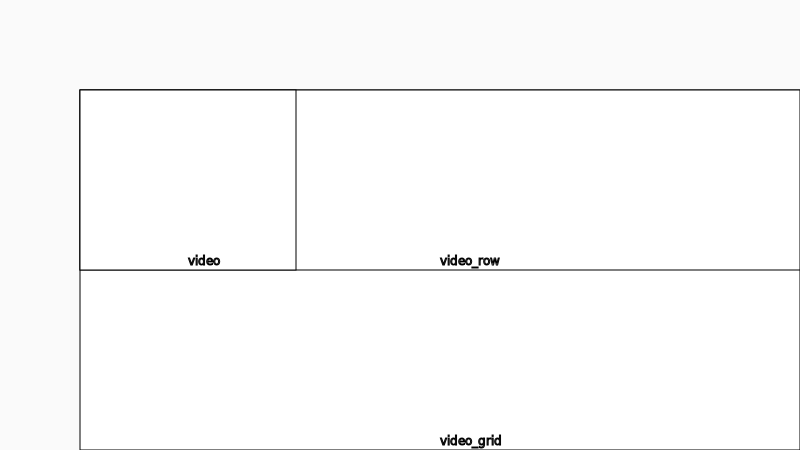

In [10]:
Locator.fromJson({'name': 'video_grid',
 'topleft': 21,
 'bottomright': 99,
 'text': '',
 'tag': '',
 'klass': '',
 'nChildren': '2',
 'children': [{'name': 'video_row',
   'topleft': 0,
   'bottomright': 49,
   'text': '',
   'tag': '',
   'klass': '',
   'nChildren': '3',
   'children': [{'name': 'video',
     'topleft': 0,
     'bottomright': 92,
     'text': '',
     'tag': '',
     'klass': '',
     'nChildren': '2',
     'children': []}]}]}).plot()

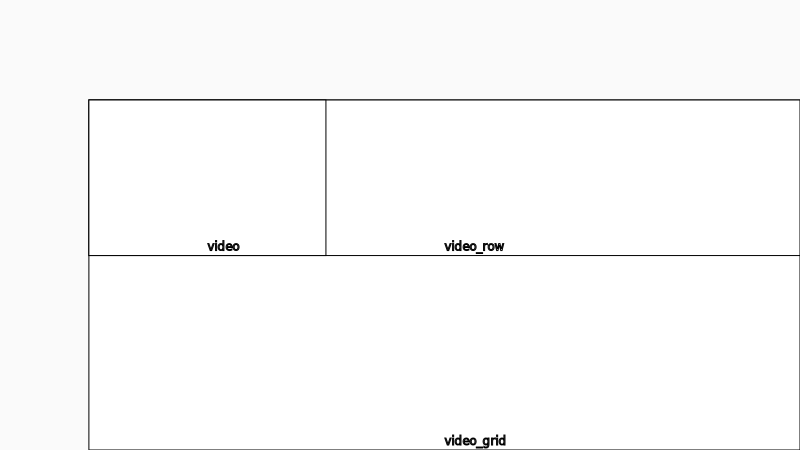

In [7]:
Locator.fromJson({'name': 'video_grid',
 'topleft': 21,
 'bottomright': 99,
 'text': '',
 'tag': '',
 'klass': '',
 'nChildren': '2',
 'children': [{'name': 'video_row',
   'topleft': 0,
   'bottomright': 49,
   'text': '',
   'tag': '',
   'klass': '',
   'nChildren': '3',
   'children': [{'name': 'video',
     'topleft': 0,
     'bottomright': 93,
     'text': '',
     'tag': '',
     'klass': '',
     'nChildren': '2',
     'children': []}]}]}).plot()

In [84]:
cli.init.patchDict()
k1lib.settings.zircon.http_server = "http://localhost:8898"
k1lib.settings.zircon.ws_server = "ws://localhost:8899"

In [85]:
b = newBrowser()

In [86]:
await b.scan()

Connecting to server...
Connected


{'_ext_734469244_1704174065_0': {'basics': {'title': 'Zircon browser automation',
   'url': 'https://staging.zircon.mlexps.com/'},
  'tabInfo': {'tabId': 2053021949,
   'bgData': {'config': {'groupPaths': ['mint2_exp']},
    'extId': '_ext_734469244_1704174065_0'}},
  'lastUpdated': 1704216748.6022124,
  'lastPing': 1704216826.7124147},
 '_ext_734469244_1704174065_35': {'basics': {'title': 'zircon.ipynb (9) - JupyterLab',
   'url': 'http://localhost:8888/lab/tree/k1lib/k1lib/zircon.ipynb'},
  'tabInfo': {'tabId': 2053020163,
   'bgData': {'config': {'groupPaths': []},
    'extId': '_ext_734469244_1704174065_35'}},
  'lastUpdated': 1704216615.4131062,
  'lastPing': 1704216826.6495225}}

In [91]:
await b.pickExtFromGroup("mint2_exp")

'ok'

In [103]:
e = await b.querySelector("div"); e

<Element DIV id="" #child=0 class="" %parent=3% %screen=3% />

In [93]:
e.extras

{'idx': '_chrome_msg_1704216951914_689708084_14',
 'id': '',
 'tag': 'DIV',
 'className': '',
 'text': "If it takes too long to load (>5s), it probably means that you haven't installed the chrome extension yet",
 'nChildren': 0,
 'screen': {'w': 893, 'h': 633},
 'coords': {'x': 8,
  'y': 160.25,
  'w': 862,
  'h': 18,
  'area': 15516,
  'areaRatio': {'screen': 0.02744887832164863,
   'parent': 0.017643275032927987}},
 'boundedCoords': {'x': 8,
  'y': 160.25,
  'w': 862,
  'h': 18,
  'area': 15516,
  'areaRatio': {'screen': 0.02744887832164863, 'parent': 0.0288}},
 'parent': {'coords': {'x': 8,
   'y': 8,
   'w': 862,
   'h': 1020.21875,
   'area': 879428.5625},
  'boundedCoords': {'x': 8, 'y': 8, 'w': 862, 'h': 625, 'area': 538750}}}

In [23]:
e.extras

{'idx': '_chrome_msg_1704215244535_592429932_680',
 'id': '',
 'tag': 'DIV',
 'text': "If it takes too long to load (>5s), it probably means that you haven't installed the chrome extension yet",
 'nChildren': 0,
 'screen': {'w': 893, 'h': 633},
 'coords': {'x': 8,
  'y': 160.25,
  'w': 862,
  'h': 18,
  'area': 15516,
  'areaRatio': {'screen': 0.02744887832164863,
   'parent': 0.018141160908317848}},
 'boundedCoords': {'x': 8,
  'y': 160.25,
  'w': 862,
  'h': 18,
  'area': 15516,
  'areaRatio': {'screen': 0.02744887832164863, 'parent': 0.0288}}}

In [9]:
games = await b.locate("Games"); games

[<Element selector=<local _chrome_msg_1701360688990_161533922_2> browser=_ext_914137376_1701350618_0>,
 <Element selector=<local _chrome_msg_1701360688990_161533922_3> browser=_ext_914137376_1701350618_0>]

In [11]:
await (await b.querySelector("h1")).value("outerHTML")

'<h1 id="firstHeading" class="firstHeading mw-first-heading"><span class="mw-page-title-main">Config</span></h1>'

In [8]:
#export
k1lib.settings.zircon.add("conflictDuration", 10, "How many seconds does the Extensions need to not take orders from other Python clients before our Python clients can take over? If too high, there won't be any free Extensions left, and if too low, there will be interference with other ppl")
class BrowserCancel(Exception): pass
class BrowserGroup:
    def __init__(self, groupPath:"str|list[str]", limit:int=3):
        """Constructs a browser group.

:param groupPath: what group of browsers do you want to take control over?
:param limit: only take over this many browsers"""
        self.groupPath = groupPath; self.limit = limit
        self._scanBrowser = newBrowser(); self._extIds = []; self._browsers = []
        self._setupFinished = False; asyncio.create_task(self._setup())
    async def _setup(self):
        with k1lib.captureStdout(): scan = await self._scanBrowser.scan(self.groupPath)
        extIds = scan.items() | cli.filt(lambda x: (time.time() - x["lastUpdated"]) > k1lib.settings.zircon.conflictDuration, 1) | cli.cut(0) | cli.deref()
        self._extIds = extIds | cli.head(self.limit) | cli.deref()
        # then have all the browsers pick the exts
        for extId in self._extIds:
            b = newBrowser()
            with k1lib.captureStdout(): await b.pickExt(extId)
            self._browsers.append(b)
        self._setupFinished = True
    async def _setupGuard(self):
        while not self._setupFinished: await asyncio.sleep(0.01)
    async def execute(self, aFn, timeout=20):
        """Executes the specified async function repeatedly whenever a browser frees up.
Example::

    linksToVisit = deque([
        'https://en.touhouwiki.net/wiki/Reimu_Hakurei',
        'https://en.touhouwiki.net/wiki/Marisa_Kirisame',
        'https://en.touhouwiki.net/wiki/Touhou_Project',
        'https://en.touhouwiki.net/wiki/Imperishable_Night',
        'https://en.touhouwiki.net/wiki/Perfect_Cherry_Blossom',
        'https://en.touhouwiki.net/wiki/Embodiment_of_Scarlet_Devil',
        'https://en.touhouwiki.net/wiki/Subterranean_Animism',
        'https://en.touhouwiki.net/wiki/Mountain_of_Faith',
        'https://en.touhouwiki.net/wiki/Phantasmagoria_of_Flower_View',
        'https://en.touhouwiki.net/wiki/Hakurei_Shrine',
        'https://en.touhouwiki.net/wiki/Touhou_Wiki:Projects',
        'https://en.touhouwiki.net/wiki/Yukari_Yakumo',
        'https://en.touhouwiki.net/wiki/Undefined_Fantastic_Object',
        'https://en.touhouwiki.net/wiki/Aya_Shameimaru',
        'https://en.touhouwiki.net/wiki/Sakuya_Izayoi',
        'https://en.touhouwiki.net/wiki/Immaterial_and_Missing_Power',
        'https://en.touhouwiki.net/wiki/Sanae_Kochiya'
    ])
    data = []

    async def crawl(b:"zircon.Browser"):
        # put here because it seems to resolve lots of problems that I have
        # when browser instances are scheduled too close together
        await asyncio.sleep(1)
        
        # if it seems like there're no more data to process, then throw zircon.BrowserCancel().
        # The current browser will never be scheduled while executing this function again
        if len(linksToVisit) == 0: raise zircon.BrowserCancel()
        
        
        url = linksToVisit.popleft()
        try: # do your normal web crawling stuff here
            await b.goto(url)
            title = await (await b.querySelector("title")).value("innerHTML")

            # save data somewhere
            data.append([url, title])
        except: linksToVisit.append(url) # try again later

    bg = zircon.BrowserGroup("public", 5)
    # bg = zircon.BrowserGroup(["public", "starcraft"], 5) # or can also be this
    await bg.execute(crawl)

The last command will run the crawl function over and over again, as long as there's a free browser
to do it. Also, by default, this will only use inactive browsers (no Python clients are sending them
commands for a while, configurable at ``settings.zircon.conflictDuration``)

Notice how I wrapped all browser interactions inside a try-except block? If some errors were to
appear, like connection lost and the system is trying to restore the connection and you don't
resolve it, .execute() will throw that same error and cancels all current tasks. So if you want
to design something that will run for a long time, catch it and try to schedule the job for later

:param aFn: async function to be executed
:param timeout: if the function takes longer than this amount of time,
    then cancel the task and make the browser available in the future
    again. Can be None, but I'd advise against that"""
        await self._setupGuard(); nCancelled = [0]; avaiBs = deque(list(self._browsers))
        n = len(self._browsers); errors = [None]; tasks = deque()
        async def inner(b):
            try:
                if timeout is None: await aFn(b); avaiBs.append(b)
                else: await asyncio.wait_for(aFn(b), timeout); avaiBs.append(b)
            except BrowserCancel: nCancelled[0] += 1
            except asyncio.TimeoutError: avaiBs.append(b)
            except Exception as e: errors[0] = [e, traceback.format_exc()]
            # print(f"Encountered error {e} while executing async function. Stopping BrowserGroup.execute(). Traceback:\n\n{traceback.format_exc()}")
        while True:
            while len(tasks) and tasks[0].done(): tasks.popleft() # cleaning up old tasks
            if errors[0]: # trouble! Cancel all current tasks and break
                for task in tasks: task.cancel()
                e, tb = errors[0]; raise Exception(f"Exception occured during BrowserGroup.execute(): {e}. Traceback:\n\n{tb}")
            print(f"\rExecuting. #browsers={n} #running={n-nCancelled[0]} #tasks={len(tasks)}  ", end="")
            try:
                if len(avaiBs) == 0:
                    if nCancelled[0] >= len(self._browsers): print("Task finished"); break
                    await asyncio.sleep(0.1)
                else: tasks.append(asyncio.create_task(inner(avaiBs.popleft())))
            except asyncio.CancelledError:
                for task in tasks: task.cancel()
                break

In [16]:
!../export.py zircon --upload=True

2024-03-26 00:55:49,806	INFO worker.py:1458 -- Connecting to existing Ray cluster at address: 192.168.1.17:6379...
2024-03-26 00:55:49,814	INFO worker.py:1633 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
./export started up - /home/kelvin/anaconda3/envs/ray2/bin/python3
----- exportAll
15781   0   61%   
10181   1   39%   
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.7
Uninstalling k1lib-1.7:
  Successfully uninstalled k1lib-1.7
running install
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg

In [13]:
!../export.py zircon

2024-03-08 06:43:03,113	INFO worker.py:1458 -- Connecting to existing Ray cluster at address: 192.168.1.17:6379...
2024-03-08 06:43:03,121	INFO worker.py:1633 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
./export started up - /home/kelvin/anaconda3/envs/ray2/bin/python3
----- exportAll
15683   0   61%   
10059   1   39%   
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.6
Uninstalling k1lib-1.6:
  Successfully uninstalled k1lib-1.6
running install
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg

In [45]:
!../export.py zircon --bootstrap=True

/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-01-02 00:38:41,440	INFO worker.py:1458 -- Connecting to existing Ray cluster at address: 192.168.1.19:6379...
2024-01-02 00:38:41,448	INFO worker.py:1633 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
----- bootstrapping
Current dir: /home/kelvin/repos/labs/k1lib, /home/kelvin/repos/labs/k1lib/k1lib/../export.py
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.4.4.5
Uninstalling k1lib-1.4.4.5:
  Successfully uninstalled k1lib-1.4.4.5
running install
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based to